In [2]:
import os
import copy
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from create_model import create_nnmodel
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

ImportError: attempted relative import with no known parent package

## Load emulator

In [54]:
emulator = create_nnmodel(5, 128, mode='128x128_disc')
data = torch.load('outputs/model__epoch_780_test_pfixed_mse_noang.pth',  map_location=torch.device('cpu'))
emulator.load_state_dict(data)

<All keys matched successfully>

In [55]:
paradf = pd.read_csv('data/testpara.csv', index_col=0)
para = np.log10(np.array(paradf[['PlanetMass', 'AspectRatio', 'Alpha', 'InvStokes1', 'FlaringIndex']]))
datatest = np.load('data/datatest_rot.npy')

In [56]:
para.shape

(233, 5)

In [57]:
datatest.shape

(233, 128, 128)

In [58]:
n=len(para)
slopes = np.array(paradf.loc[0:n-1, 'SigmaSlope'])
 #initial conditions
import loader 
ic_inputs = loader.generate_ict(slopes, '128x128_disc')


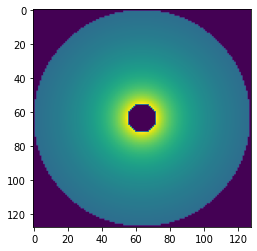

In [59]:
plt.imshow(ic_inputs[0,0])

In [60]:
para.shape

(233, 5)

In [61]:
n=50
with torch.inference_mode():
    res =emulator(torch.tensor(ic_inputs[0:n].astype(np.float32)), torch.tensor(np.float32(para[0:n])))

In [62]:
def getprofile(data, x, y, r, mode='cyl'):
    if mode=='cart':
        rho = RegularGridInterpolator((x, y), data, bounds_error=False, method='cubic')
        theta = np.linspace(-np.pi, np.pi, 300)
        rr, tt = np.meshgrid(r, theta)
        xx = rr*np.cos(tt)
        yy = rr*np.sin(tt)
        datacyl = np.nan_to_num(rho((xx, yy)))
        return datacyl.mean(axis=0)
    else:
        return data.mean(axis=0)

Text(0.5, 0.9, 'Emulator vs Simulator')

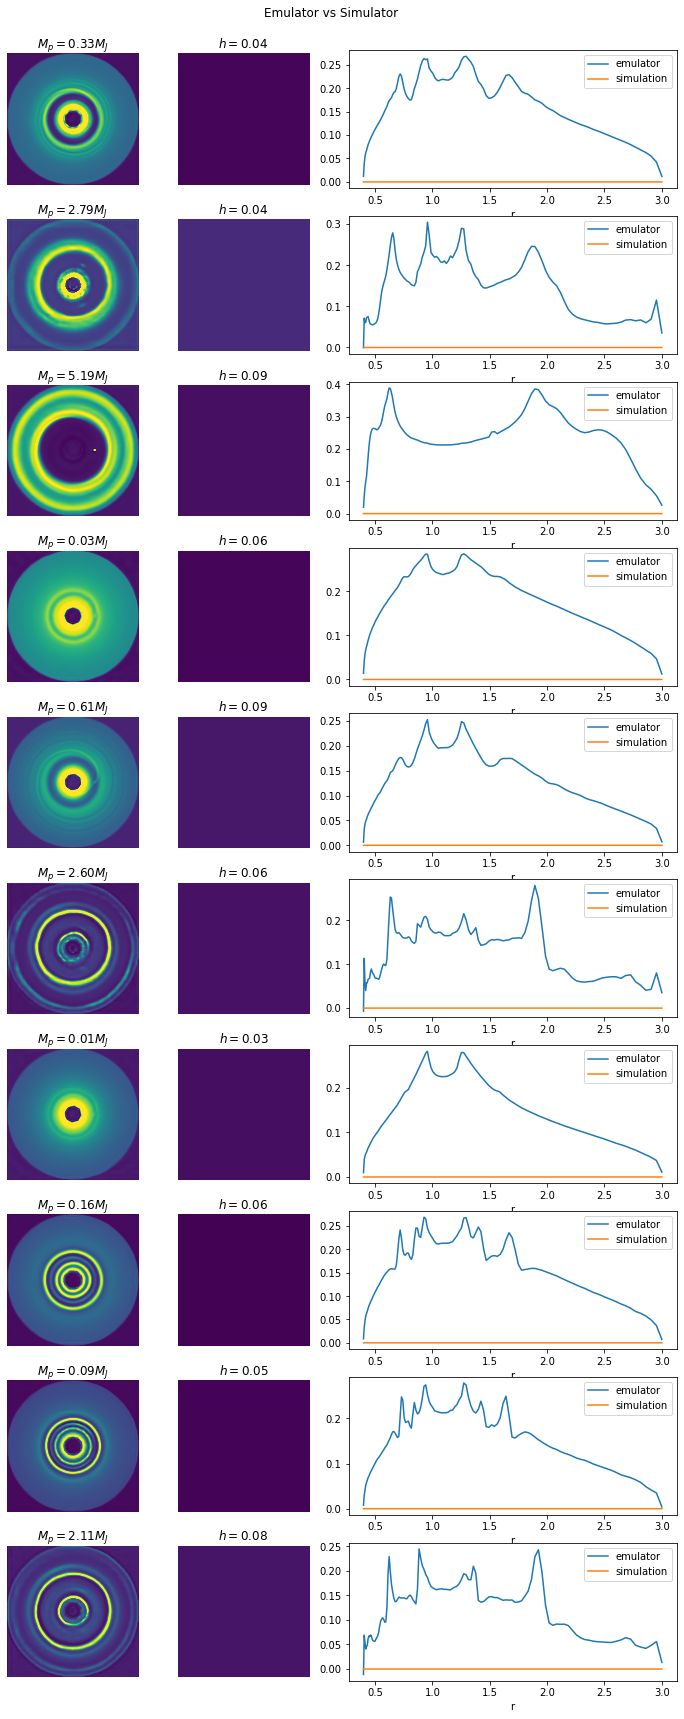

In [59]:
x = np.linspace(-3,3, 128)
y = np.linspace(-3, 3, 128)
r = np.logspace(np.log10(0.4),np.log10(3),128)

fig, axs = plt.subplots(10,3, figsize=(12,30), gridspec_kw={'width_ratios': [1,1,2.5]})
for i in range(0,10):
    
    vmax = np.percentile(np.concatenate([res[i,0], datatest[i]]).reshape(-1), 99)
    vmin = np.percentile(np.concatenate([res[i,0], datatest[i]]).reshape(-1), 0)
    
    axs[i][0].imshow(((res[i,0])), vmax=vmax, vmin=vmin)
    axs[i][1].imshow(((datatest[i])), vmax=vmax, vmin=vmin)
    axs[i][0].axis('off')
    axs[i][1].axis('off')
    axs[i][0].set_title(f'$M_p = {paradf.loc[i, "PlanetMass"]*1e3:.2f} M_J$')
    axs[i][1].set_title(f'$h = {paradf.loc[i, "AspectRatio"]:.2f}$')

    p = getprofile(np.array(res[i,0]), x, y, r)
    axs[i][2].plot(r, p, label='emulator')
    preal = getprofile(datatest[i], x, y, r)
    axs[i][2].plot(r, preal, label='simulation')
    axs[i][2].legend()
    axs[i][2].set_xlabel('r')
fig.suptitle('Emulator vs Simulator', x=0.5,y=0.9)
#plt.savefig('100epochs_2ndrun.png', dpi=500, bbox_inches='tight')

In [67]:
import os
savedir = 'mse'
os.mkdir(savedir)


FileExistsError: [Errno 17] File exists: 'mse'

In [68]:
from params import scaleandlog as sl

In [69]:
datatestr = np.expand_dims(datatest, axis=1)

In [70]:
datatestr.shape

(233, 1, 128, 128)

In [71]:
((sl(datatestr, 1e-5)[0:10]-np.array(res))**2).mean()

ValueError: operands could not be broadcast together with shapes (10,1,128,128) (50,1,128,128) 

/tmp/ipykernel_7973/91866338.py:20: RuntimeWarning: divide by zero encountered in divide
  resi = np.array((10**res[i,0]-1)/(10**test_im-1))
/tmp/ipykernel_7973/91866338.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1,4, figsize=(16,3), gridspec_kw={'width_ratios':[1,1,1.2,2]})
/tmp/ipykernel_7973/91866338.py:20: RuntimeWarning: invalid value encountered in divide
  resi = np.array((10**res[i,0]-1)/(10**test_im-1))


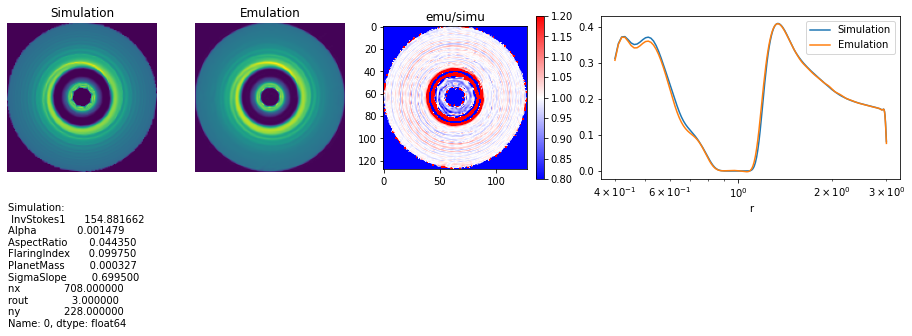

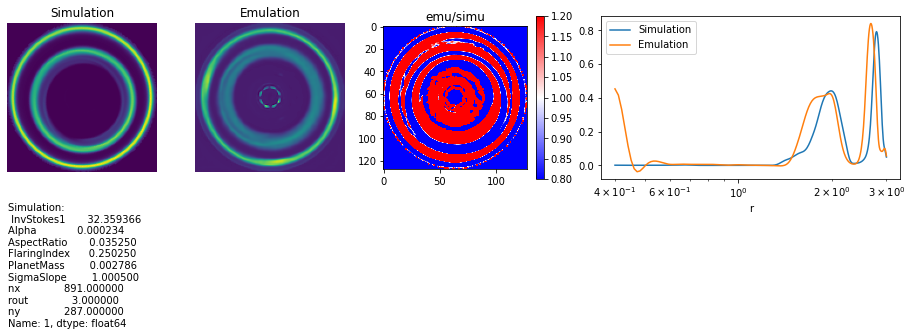

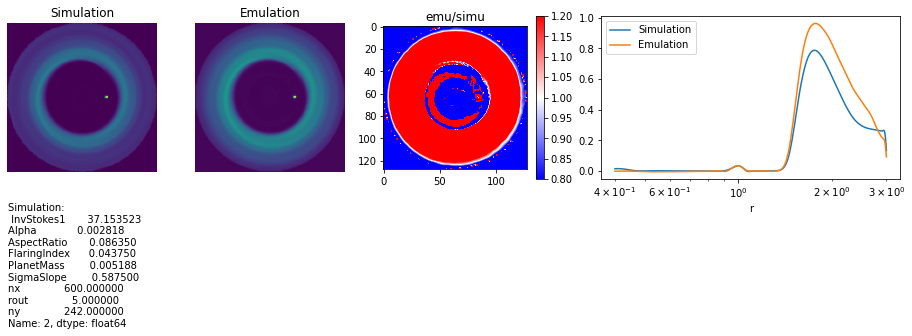

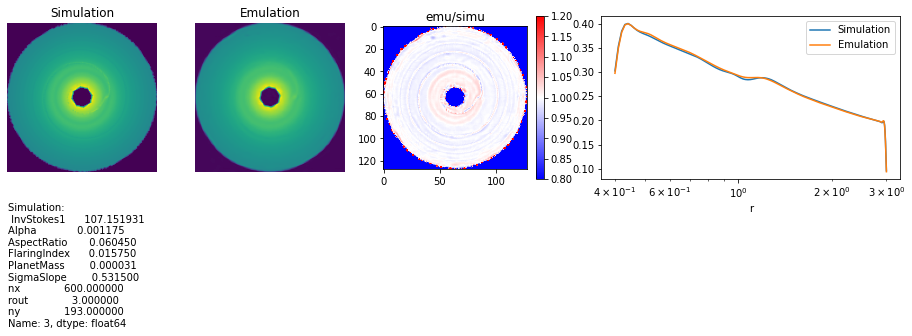

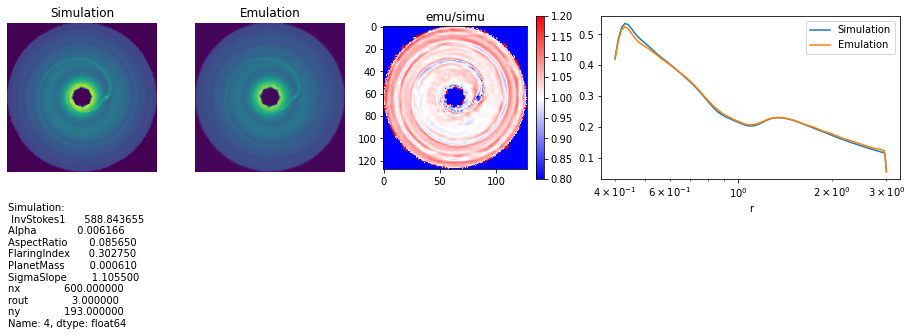

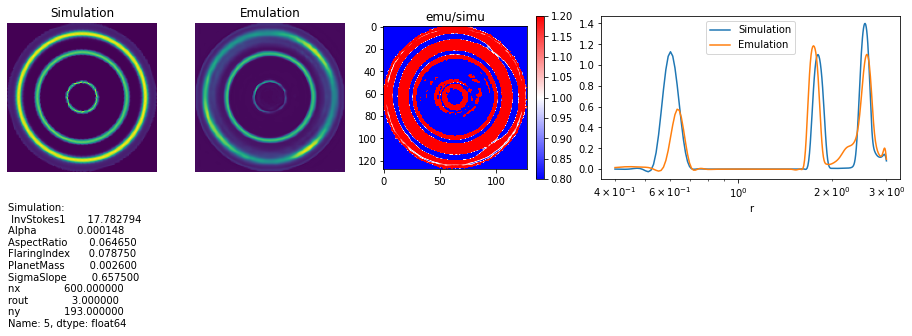

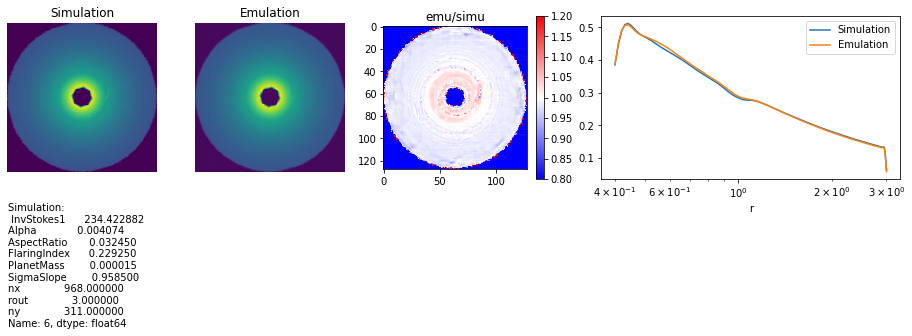

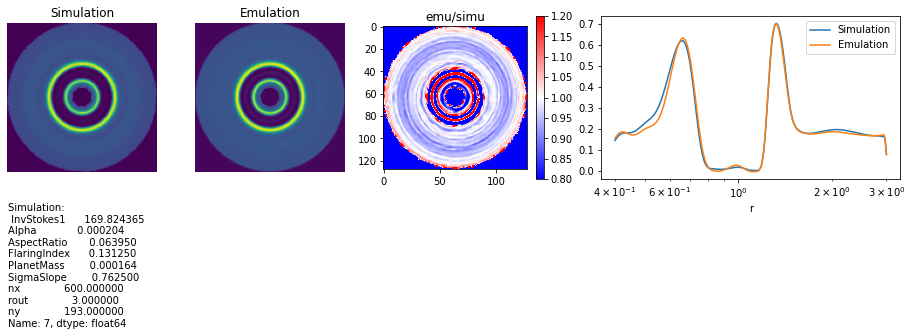

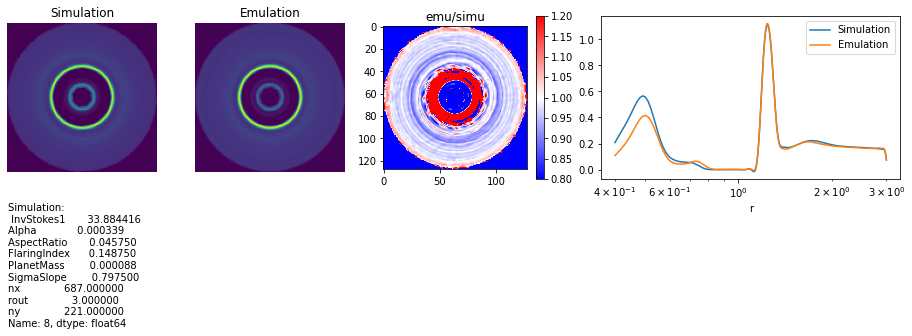

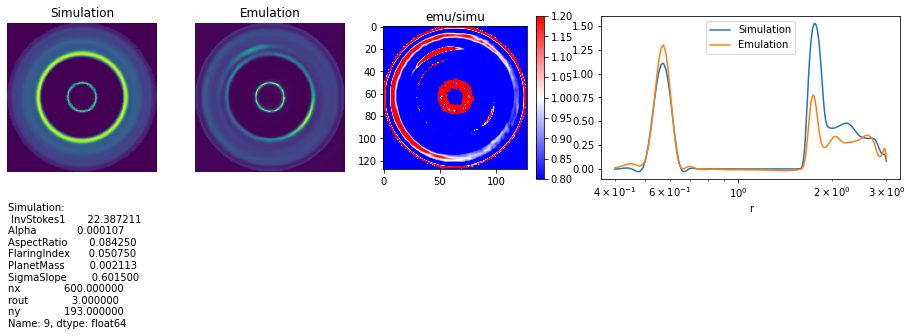

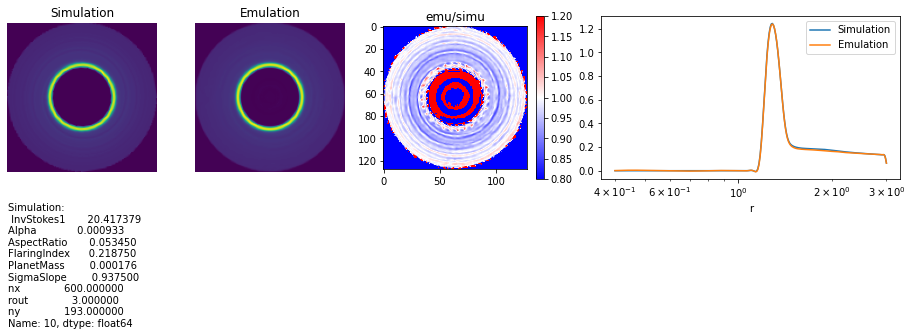

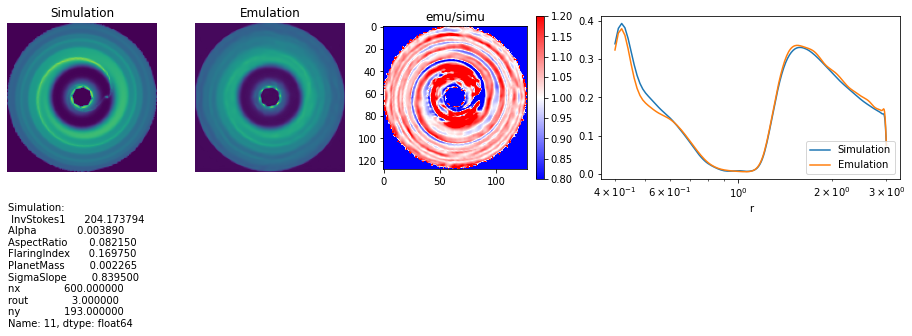

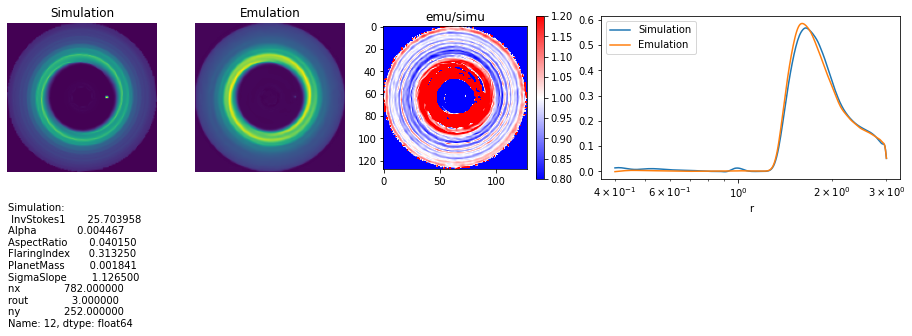

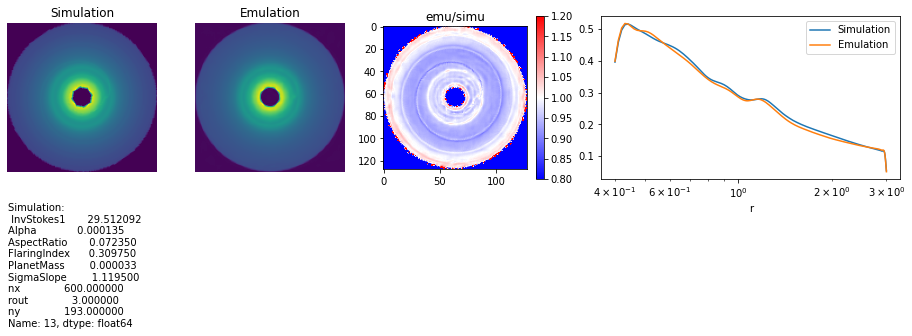

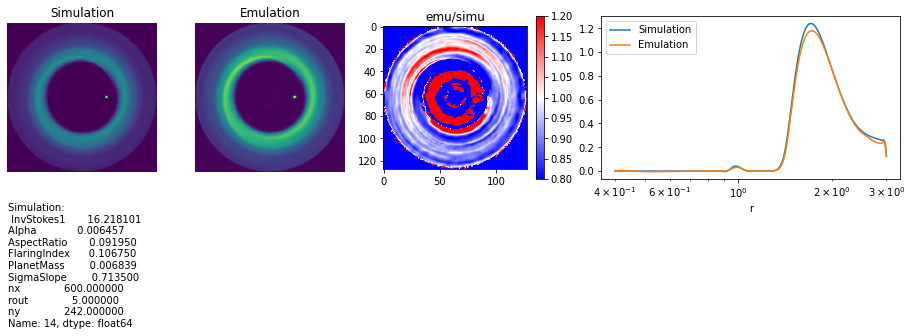

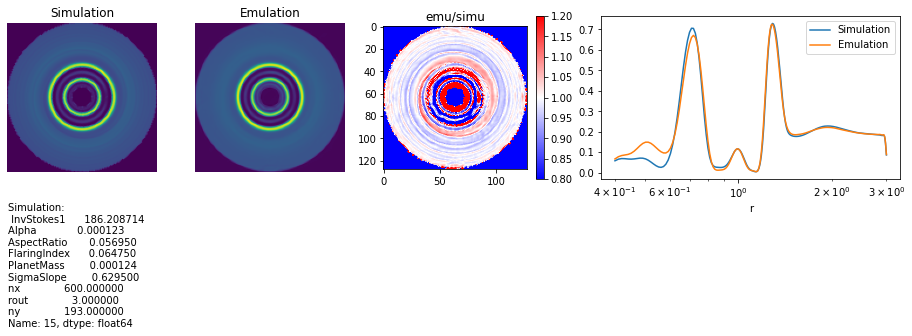

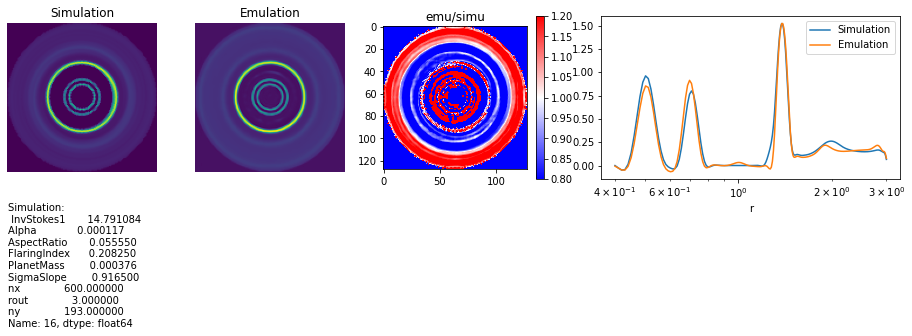

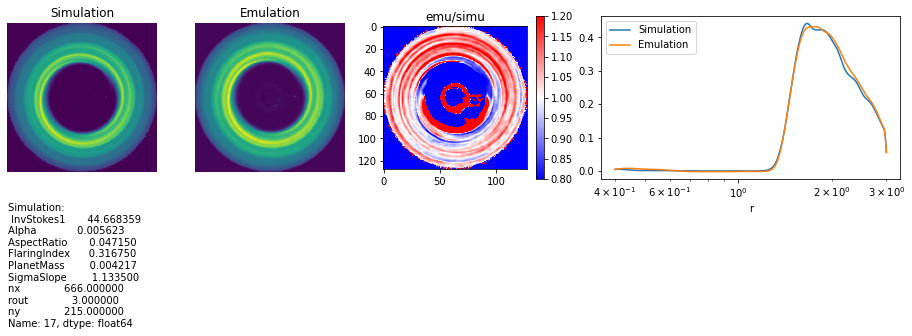

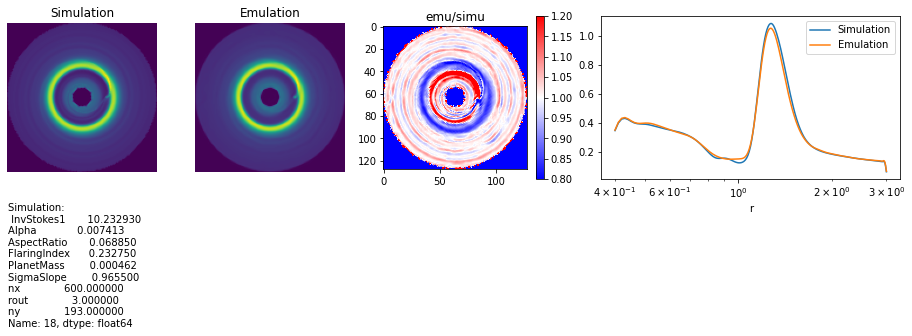

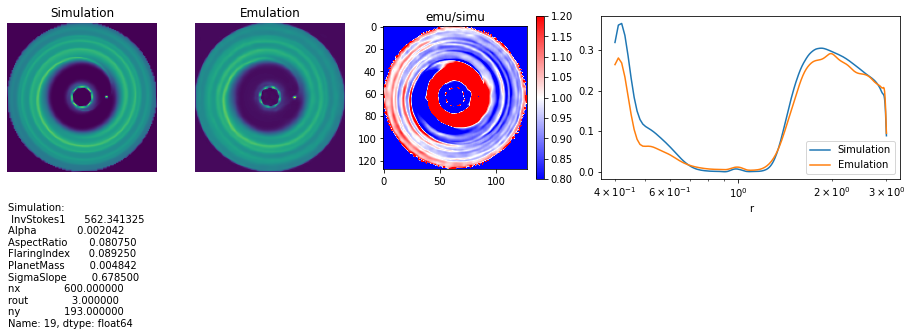

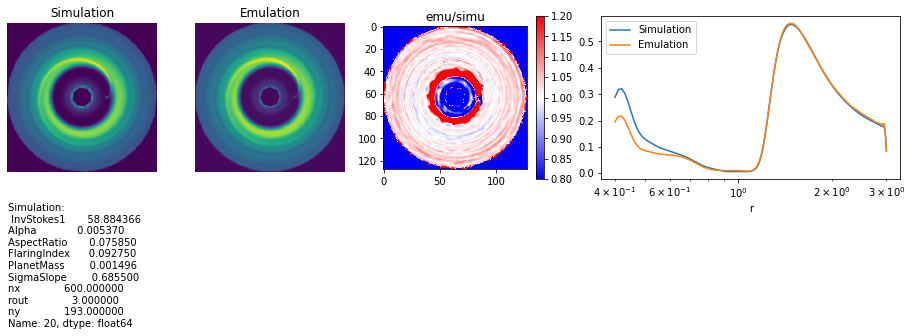

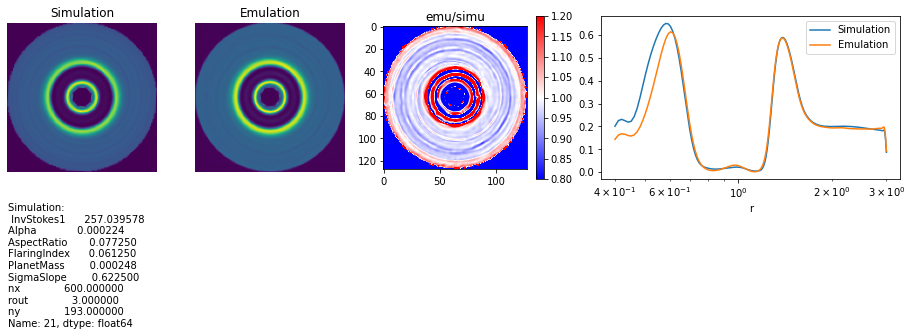

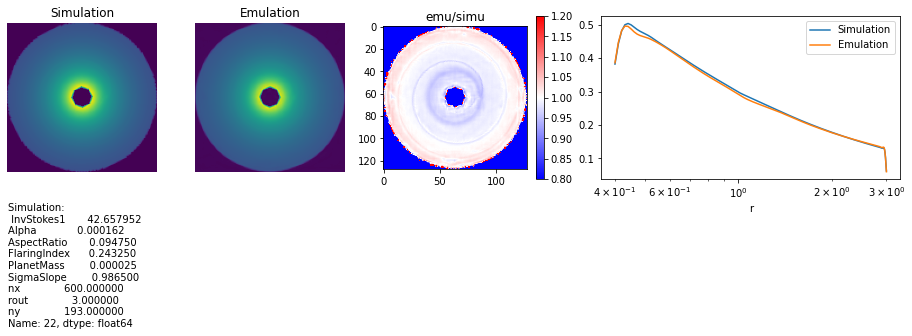

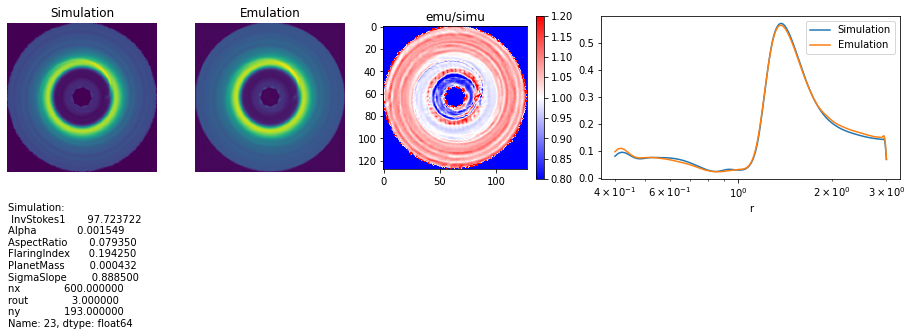

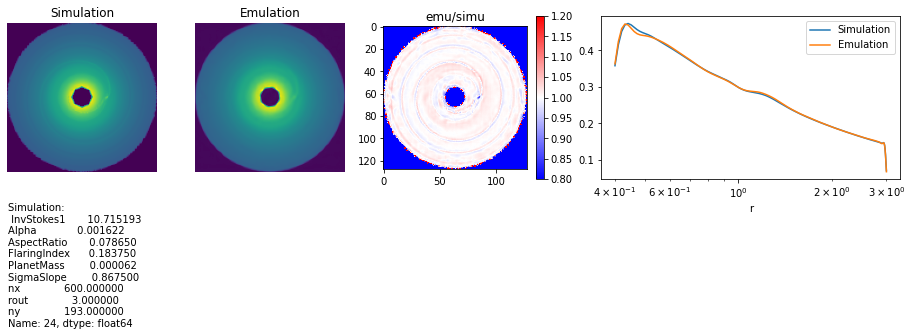

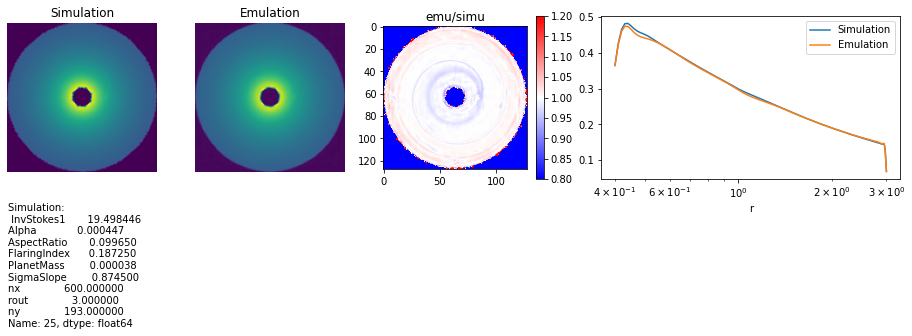

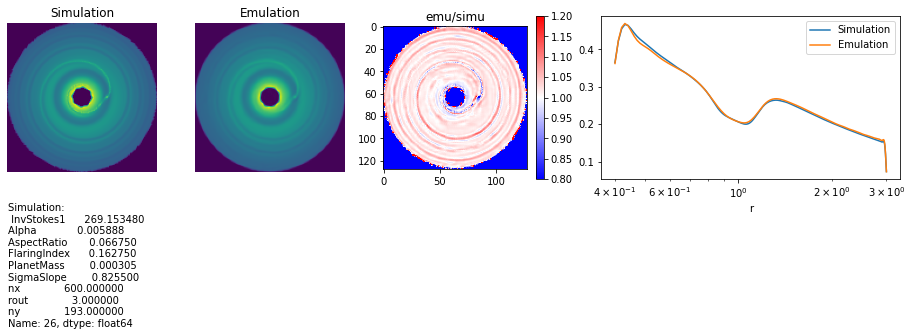

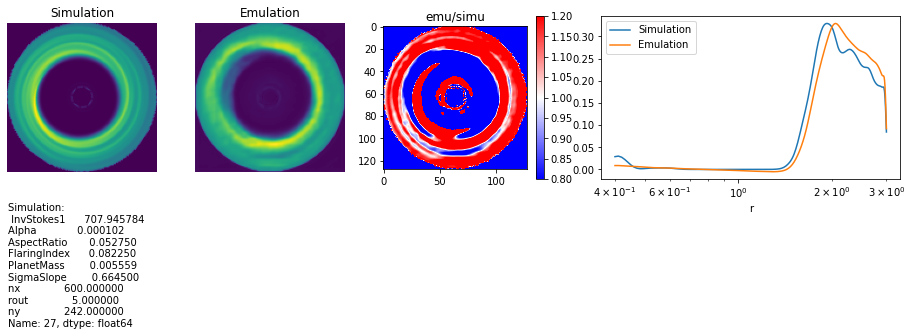

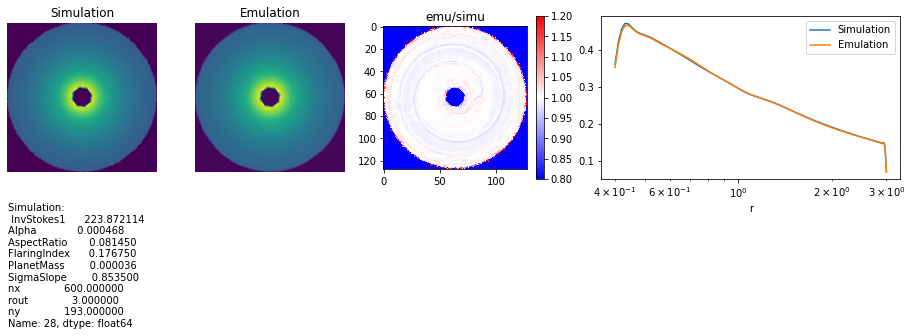

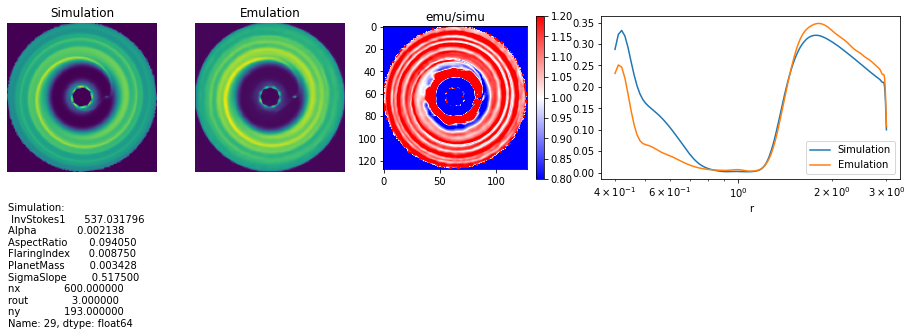

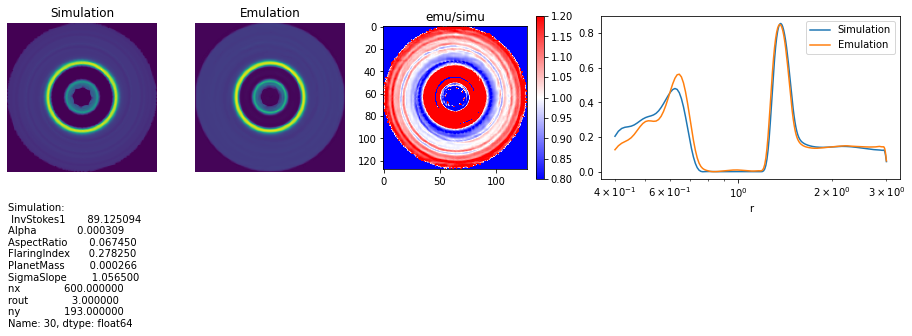

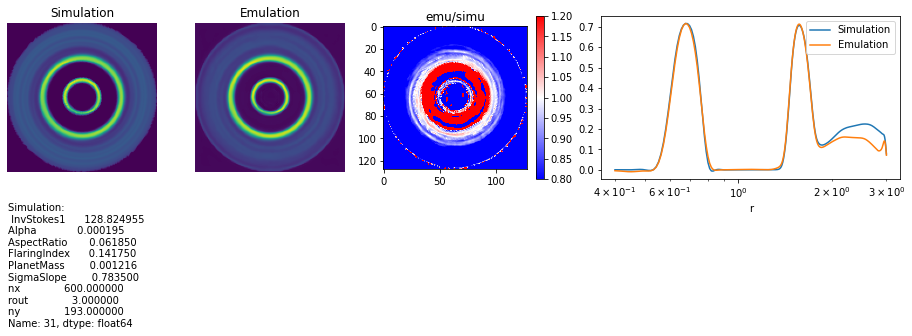

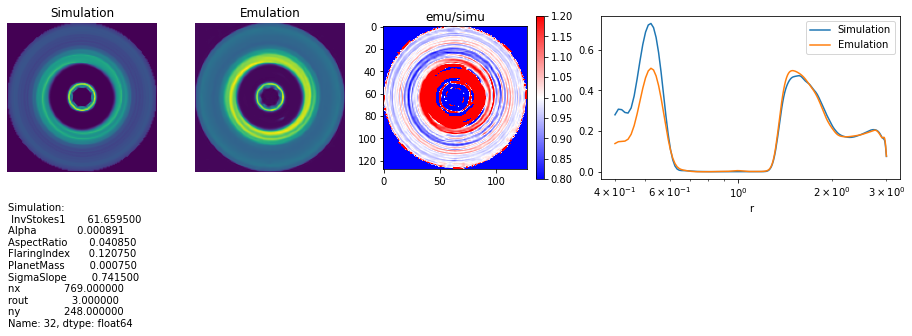

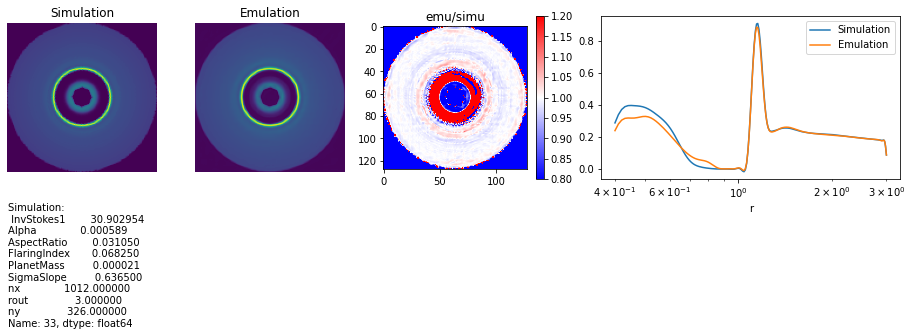

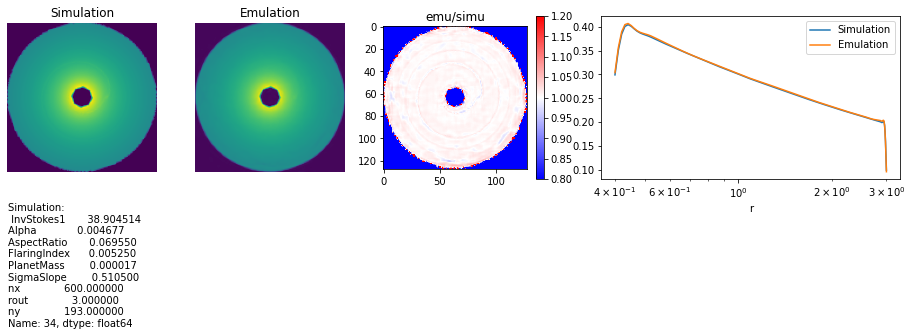

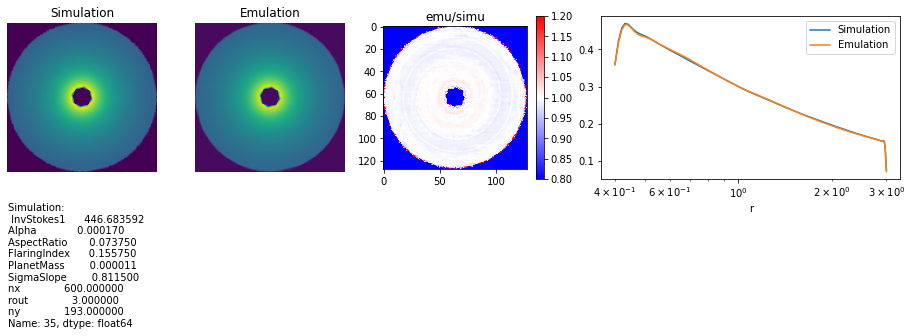

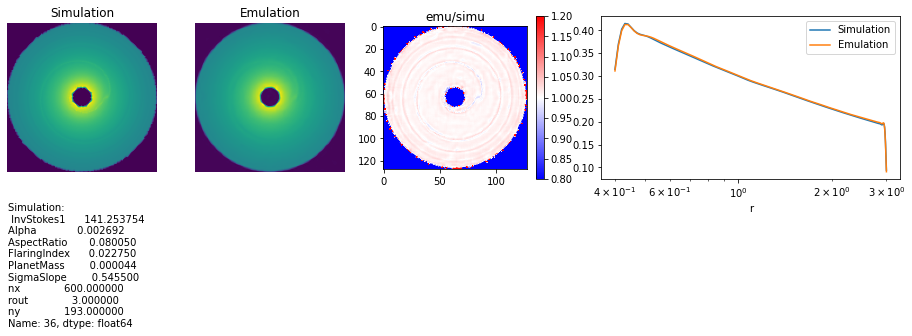

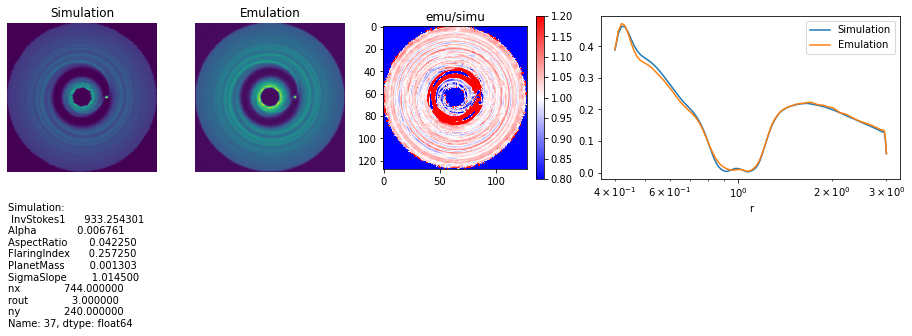

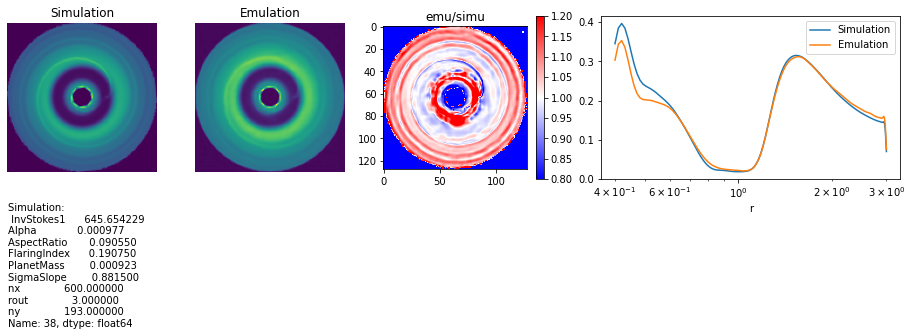

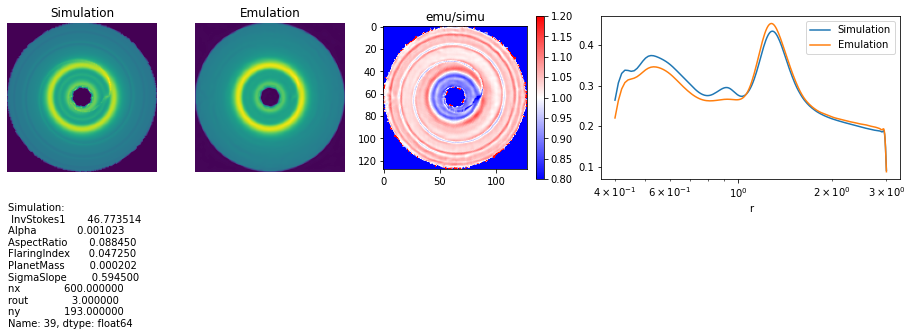

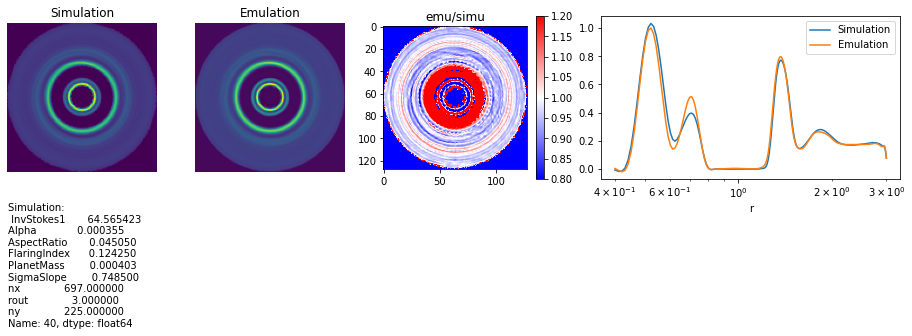

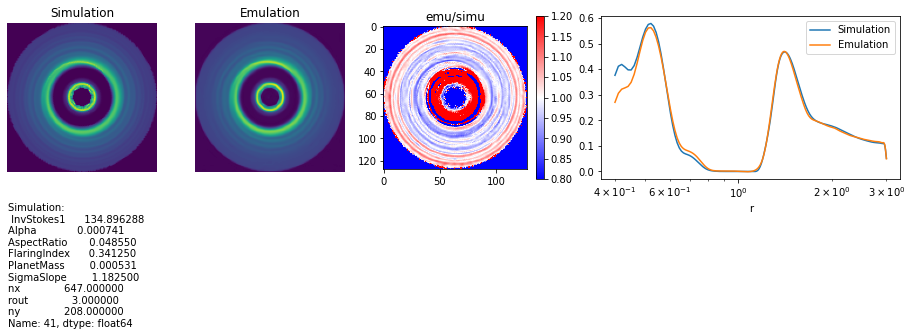

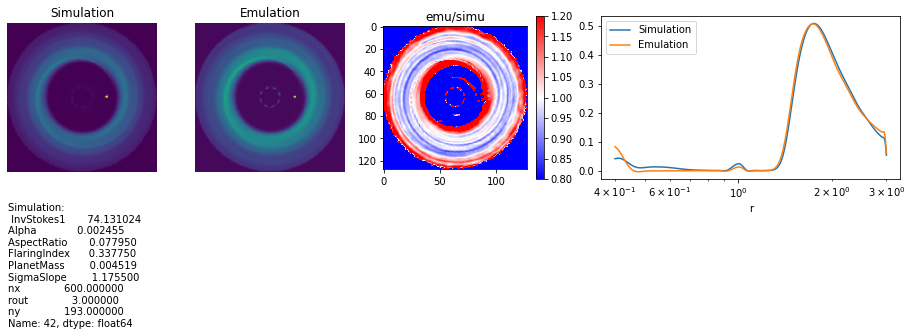

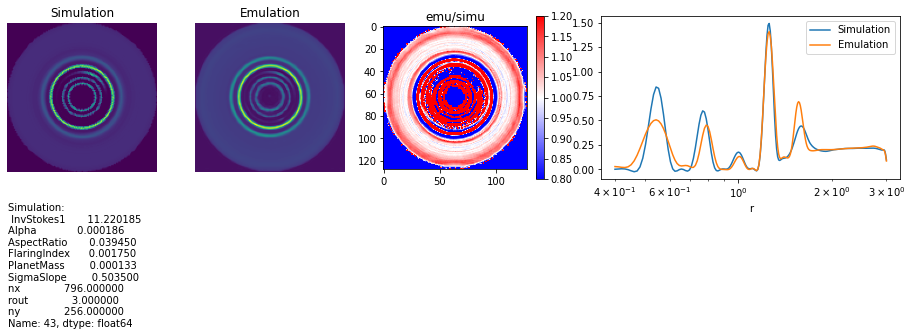

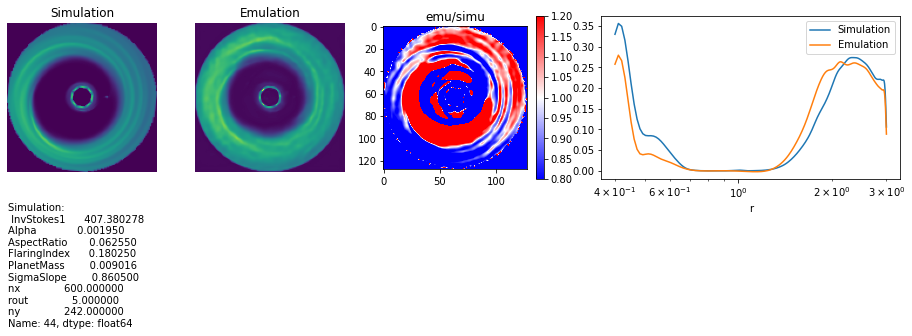

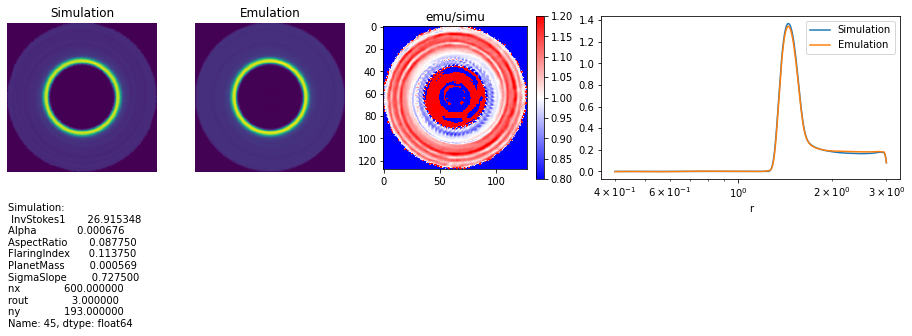

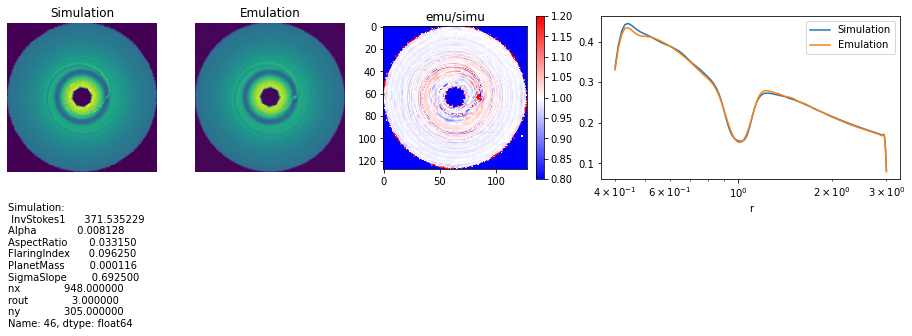

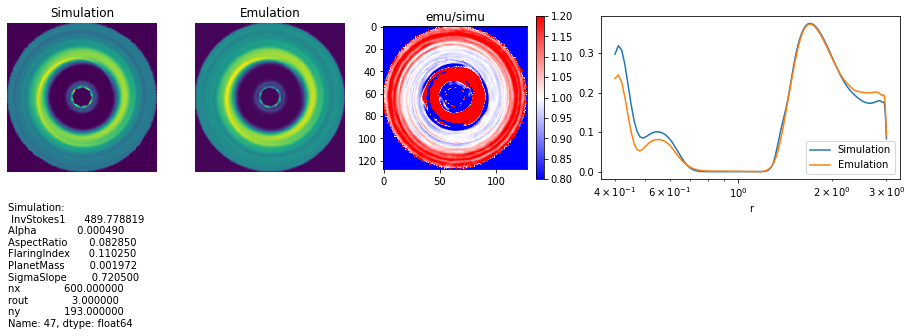

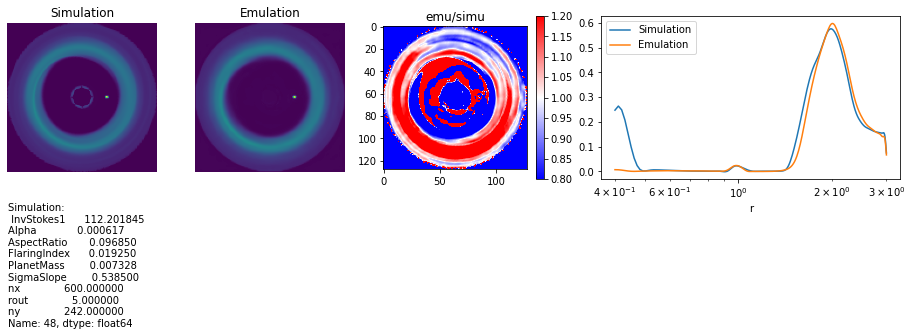

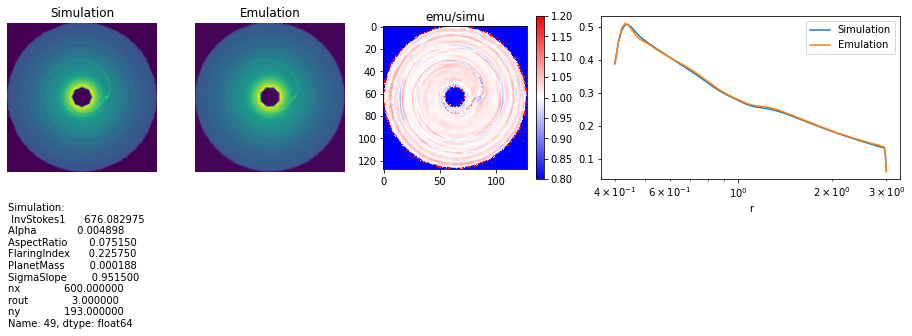

In [72]:
for i in range(len(res)):
    fig, axs = plt.subplots(1,4, figsize=(16,3), gridspec_kw={'width_ratios':[1,1,1.2,2]})
    #i=89
    #index of the simulation in the test set
    test_im = sl(datatest[i], 1e-5)
    #distsim = ((dataset-test_im)**2).mean(axis=(1,2))
    #closest = np.argmin(distsim)
    #pemu = testpara_arr[i][[4,2,1,0,3]]
    #emulation = emulator(torch.tensor(ic.reshape(1,1,128,128)), torch.tensor(np.float32(pemu.reshape(1,-1))))
    
    x = np.linspace(-3, 3, 128)
    y = np.linspace(-3, 3, 128)
    r = np.linspace(0.4,3,256)
    axs[0].imshow(test_im)
    axs[0].set_title('Simulation')
    #axs[1].set_title('Closest simulation \n in training dataset')
    axs[1].set_title('Emulation')
    #axs[1].imshow(dataset[closest])
    axs[1].imshow(res[i,0])
    resi = np.array((10**res[i,0]-1)/(10**test_im-1))
    axs[2].set_title('emu/simu')
    from numpy import inf
    resi[np.abs(resi)==inf] = 0
    lim = np.percentile(np.nan_to_num(np.abs(resi-1).flatten()), 100)
    c = axs[2].imshow(resi, vmin=0.8, vmax=1.2, cmap='bwr')
    plt.colorbar(c)
    axs[3].plot(r, getprofile(test_im, x, y, r, mode='cart'), label='Simulation')
    #axs[2].plot(r, getprofile(dataset[closest], x, y, r), label='Closest in training')
    axs[3].plot(r, getprofile(np.array(res[i,0]), x, y, r, mode='cart'), label='Emulation')
    axs[3].set_xscale('log')
    axs[3].set_xlabel('r')
    axs[3].legend()
    axs[0].text(0,260,f'Simulation: \n {paradf.loc[i]}')
    #axs[1].text(0,260,f'Closest: \n {para.loc[closest]}')
    #axs[2].text(0,150,f"mse w closest: {((test_im-dataset[closest])**2).mean():.3e} \nmse w emulation: {((test_im-np.array(emulation.detach()[0,0]))**2).mean():.3e} \
    #")
    for j in range(2):
        axs[j].axis('off')
    plt.savefig(f'{savedir}/{i}.png', dpi=300, bbox_inches='tight')

In [35]:
resi

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])